# MergeSpectroPhotoFactory

- creation date : July 4th 2019
- author Sylvie Dagoret

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec

import numpy as np
import os
from scipy.interpolate import interp1d

from astropy.time import Time


In [39]:
from astropy.table import Table,QTable

In [40]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(10,10)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

In [41]:
def GetTables(tablesdir):
    """
    """
    fn_info=os.path.join(tablesdir,"Info.npy")
    fn_wl=os.path.join(tablesdir,"Lambdas_ref.npy")
    fn_msk=os.path.join(tablesdir,"Mask.npy")
    fn_att=os.path.join(tablesdir,"MAttenuation_mean_ALL.npy")
    fn_atterr=os.path.join(tablesdir,"MAttenuation_Err_ALL.npy")

    general_info=np.load(fn_info)
    Lambdas_ref=np.load(fn_wl)
    mask= np.load("Mask.npy")
    
    #read masked arrays
    compressed=np.load(fn_att)
    values = np.zeros_like(mask, dtype=compressed.dtype)
    np.place(values, ~mask, compressed)
    MAttenuation_mean_ALL = np.ma.MaskedArray(values, mask)
    
    compressed=np.load(fn_atterr)
    values = np.zeros_like(mask, dtype=compressed.dtype)
    np.place(values, ~mask, compressed)
    MAttenuation_Err_ALL = np.ma.MaskedArray(values, mask)
    
    
    return general_info,Lambdas_ref,MAttenuation_mean_ALL,MAttenuation_Err_ALL
   

# Import Photometric Data

In [42]:
t = Table.read('out_starphotometryfactory/table_starphotometry.ecsv', format='ascii.ecsv')

In [43]:
t[:5]

idx,Npixcirc,fracpixcirc,sigcirc,errstatcirc,errannul,sigx,sigy,bkgsum,bkgaverpix,bkgstddevpix,airmass,x0,y0,date,file
int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,object,str117
0,1935,0.9855,2.779e+06,760.9,2.533e+04,4.709,4.541,185746.69,94.6,13.09,1.546,417,90,2019-02-15T22:55:50.730,/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit
1,1937,0.9865,2.779e+06,761,2.504e+04,4.938,4.673,183848.64,93.63,12.92,1.543,417,86,2019-02-15T22:56:26.007,/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190215_225626_007_HD116405_Filtre_None_bin1x1.2_red.fit
2,1932,0.984,2.78e+06,761.1,2.485e+04,4.713,4.556,185718.44,94.59,12.86,1.54,417,87,2019-02-15T22:57:01.284,/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190215_225701_284_HD116405_Filtre_None_bin1x1.3_red.fit
3,1932,0.984,2.637e+06,741.1,2.523e+04,5.129,4.702,183084.86,93.24,13.06,1.537,467,43,2019-02-15T22:57:36.562,/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190215_225736_562_HD116405_Filtre_None_bin1x1.4_red.fit
4,1933,0.9845,2.646e+06,742.5,2.494e+04,5.154,4.46,181000.45,92.18,12.9,1.534,464,43,2019-02-15T22:58:11.838,/Users/dagoret/DATA/PicDuMidiFev2019/prod_20190215_v4/T1M_20190215_225811_838_HD116405_Filtre_None_bin1x1.5_red.fit


In [44]:
t["starmag"]=-2.5*np.log10(t["sigcirc"])
t["bkgmag"]=-2.5*np.log10(t["bkgsum"])

t["starmagerr"]=2.5/2.3/t["sigcirc"]*np.sqrt(t["errstatcirc"]**2+t["errannul"]**2)
t["bkgmagerr"]=2.5/2.3/t["bkgsum"]*t["bkgstddevpix"]*2000.

In [69]:
Nobs1=len(t)

In [71]:
Nobs1

287

## Convert in datetime

- necessary for plotting

In [68]:
all_datetime1 = [Time(d,format='isot', scale='utc').to_datetime()  for d in t["date"]]

# Import spectrometric data

In [47]:
tabledir2="out_processgreyattenuation"

In [48]:
general_info,Lambdas_ref,MAttenuation_mean_ALL,MAttenuation_Err_ALL=GetTables(tabledir2)

In [67]:
all_indexes2=general_info[:,0]
all_eventnum2=general_info[:,1]
all_airmass2=general_info[:,2]
all_dt2=general_info[:,3]
all_datetime2=general_info[:,4]
all_referencebasedattenuation2=general_info[:,5]
all_flag2=general_info[:,6]

In [50]:
NWLBIN,Nobs2=MAttenuation_mean_ALL.shape

# Association

In [81]:
map_photo_to_spectro_idx= [ np.where(all_datetime2==time1)[0][0] for time1 in all_datetime1]

# Try correlations

In [105]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWLBIN)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWLBIN), alpha=1)

0 382.5
50 632.5
100 882.5


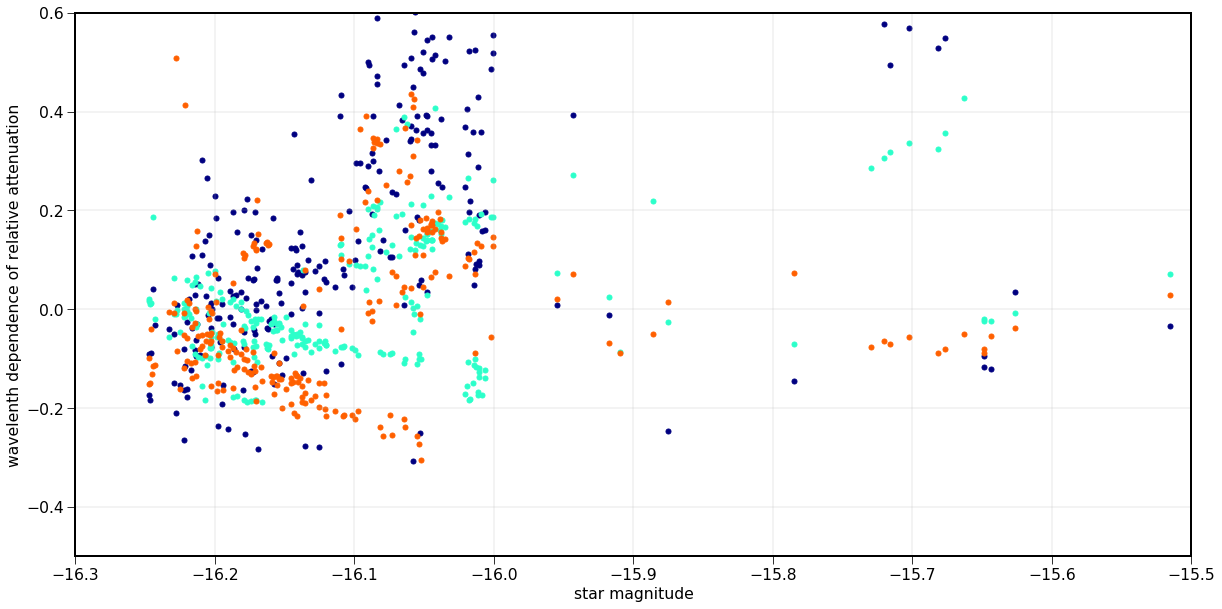

In [114]:
plt.figure(figsize=(20,10))
for iwl in np.arange(NWLBIN):
    if iwl%50==0:
        print(iwl,Lambdas_ref[iwl])
        plt.scatter(t["starmag"],MAttenuation_mean_ALL[iwl,map_photo_to_spectro_idx],marker="o",color=all_colors[iwl])
plt.xlabel("star magnitude")
plt.ylabel("wavelenth dependence of relative attenuation")
plt.xlim(-16.3,-15.5)
plt.ylim(-0.5,0.6)
plt.grid()


(-1.0, 1.0)

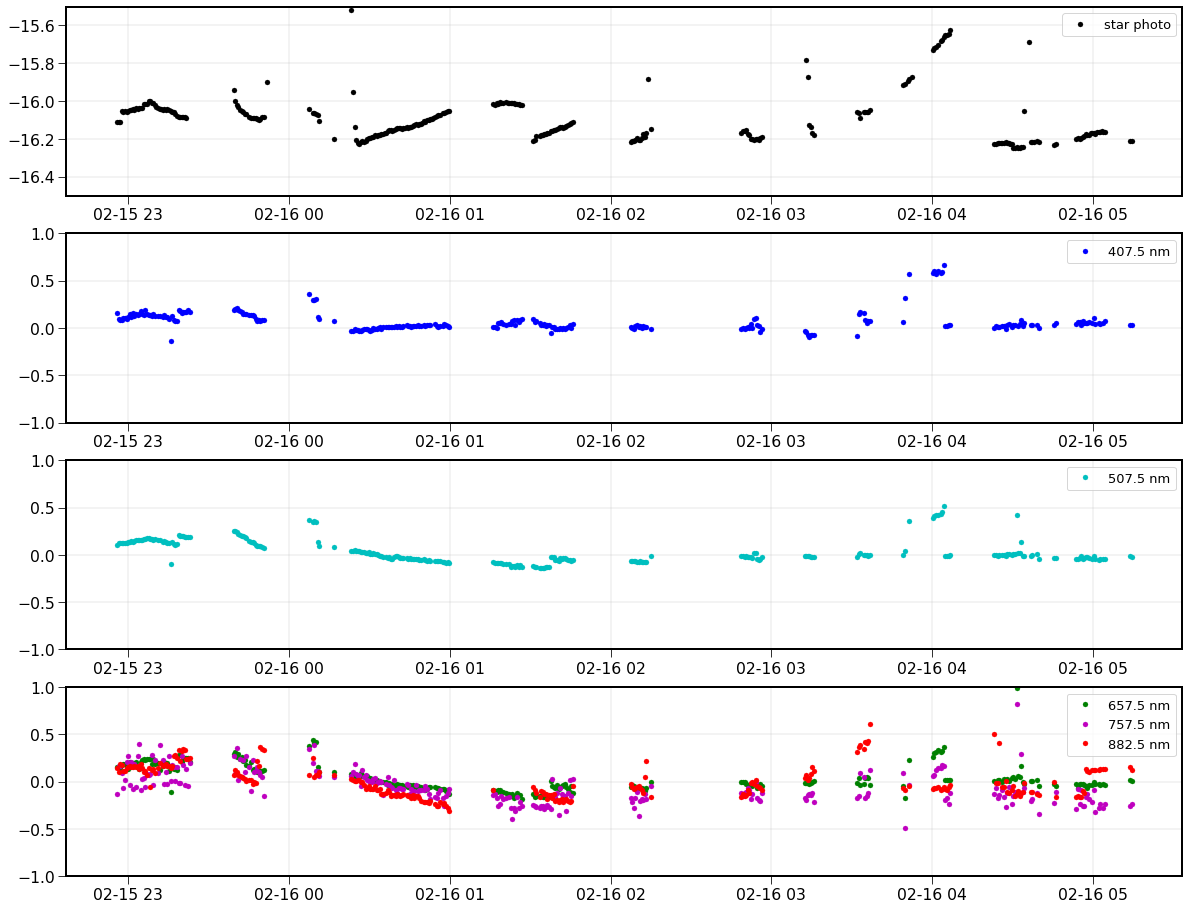

In [136]:
plt.figure(figsize=(20,16))
plt.subplot(4,1,1)
plt.plot(all_datetime1,t["starmag"],'ko',label="star photo")
plt.ylim(-16.5,-15.5)
plt.grid()
plt.legend()
plt.subplot(4,1,2)
iwl=5
plt.plot(all_datetime1,MAttenuation_mean_ALL[iwl,map_photo_to_spectro_idx],'bo',label="{} nm".format(Lambdas_ref[iwl]))
plt.grid()
plt.legend()
plt.ylim(-1.,1.)
plt.subplot(4,1,3)
plt.ylim(-1.,1.)
iwl=25
plt.plot(all_datetime1,MAttenuation_mean_ALL[iwl,map_photo_to_spectro_idx],'co',label="{} nm".format(Lambdas_ref[iwl]))
plt.grid()
plt.legend()
plt.subplot(4,1,4)
iwl=55
plt.plot(all_datetime1,MAttenuation_mean_ALL[iwl,map_photo_to_spectro_idx],'go',label="{} nm".format(Lambdas_ref[iwl]))
plt.grid()
plt.legend()
plt.ylim(-1.,1.)
iwl=75
plt.plot(all_datetime1,MAttenuation_mean_ALL[iwl,map_photo_to_spectro_idx],'mo',label="{} nm".format(Lambdas_ref[iwl]))
plt.grid()
plt.legend()
plt.ylim(-1.,1.)
iwl=100
plt.plot(all_datetime1,MAttenuation_mean_ALL[iwl,map_photo_to_spectro_idx],'ro',label="{} nm".format(Lambdas_ref[iwl]))
plt.grid()
plt.legend()
plt.ylim(-1.,1.)